<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuroAI-NMA/blob/main/tutorials/W2D4_Macrolearning/student/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Meta-learning

**Week 2, Day 4: Macro-Learning**

**By Neuromatch Academy**

__Content creators:__ Hlib Solodzhuk, Ximeng Mao, Grace Lindsay

__Content reviewers:__ Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Hlib Solodzhuk, Ximeng Mao, Samuele Bolotta, Grace Lindsay

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

___


# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

In this tutorial, you will examine how meta-learning separates the problem of continual learning into two stages.

In [2]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "t36w8"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup



In [3]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D4_T3"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.7 MB/s eta 0:00:00


In [4]:
# @title Imports

#working with data
import numpy as np
from functools import partial

#plotting
import matplotlib.pyplot as plt
import logging
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

#interactive display
import ipywidgets as widgets

#modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

#utils
from tqdm import tqdm

In [5]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting functions

def plot_tasks(task_days, task_prices):
    """
    Plot the tasks' prices over time.

    Inputs:
    - task_days (list): A list of three lists, where each sub-list contains the days for a specific task.
    - task_prices (list): A list of three lists, where each sub-list contains the prices for a specific task.
    """
    sorted_first_task_days, sorted_first_task_prices = zip(*sorted(zip(task_days[0], task_prices[0]), key=lambda pair: pair[0]))
    sorted_second_task_days, sorted_second_task_prices = zip(*sorted(zip(task_days[1], task_prices[1]), key=lambda pair: pair[0]))
    sorted_third_task_days, sorted_third_task_prices = zip(*sorted(zip(task_days[2], task_prices[2]), key=lambda pair: pair[0]))

    with plt.xkcd():
      plt.plot(sorted_first_task_days, sorted_first_task_prices, label = "First Task")
      plt.plot(sorted_second_task_days, sorted_second_task_prices, label = "Second Task")
      plt.plot(sorted_third_task_days, sorted_third_task_prices, label = "Third Task")
      plt.xlabel('Week')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

def plot_inner_outer_weights(pca_parameters, epoch):
    """
    Plot PCA-transformed outer weights of the model in 2D over the epochs as well as inner / outer weights for the given epoch

    Inputs:
    - pca_parameters (np.ndarray): array of model parameters (already in 2D).
    - epoch (int): given epoch.
    """
    with plt.xkcd():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        #plot points for the given epoch
        for j in range(pca_parameters.shape[1]):
            ax1.scatter(pca_parameters[epoch - 1, j, 0], pca_parameters[epoch - 1, j, 1], color='k', s=10)

        start_point = pca_parameters[epoch - 1, 0]

        #plot arrows from start point to all other
        for j in range(1, pca_parameters.shape[1]):
            #inner
            end_point = pca_parameters[epoch - 1, j]
            arrow_color = 'g'
            #outer
            if j == pca_parameters.shape[1] - 1:
                arrow_color = 'b'
            ax1.annotate('', xy=end_point, xytext=start_point,
                    arrowprops=dict(arrowstyle='->', color=arrow_color))
        #plot arrows for previous outer
        for j in range(epoch - 1):
            ax1.scatter(pca_parameters[j, 0, 0], pca_parameters[j, 0, 1], color='k', s=10)
            start_point = pca_parameters[j, 0]
            end_point = pca_parameters[j + 1, 0]
            ax1.annotate('', xy=end_point, xytext=start_point,
                    arrowprops=dict(arrowstyle='->', color='b', alpha = 0.2))

        #plot points for the given epoch
        for j in range(pca_parameters.shape[1]):
            ax2.scatter(pca_parameters[epoch - 1, j, 0], pca_parameters[epoch - 1, j, 1], color='k', s=10)

        start_point = pca_parameters[epoch - 1, 0]

        #plot arrows from start point to all other
        for j in range(1, pca_parameters.shape[1]):
            #inner
            end_point = pca_parameters[epoch - 1, j]
            arrow_color = 'g'
            #outer
            if j == pca_parameters.shape[1] - 1:
                arrow_color = 'b'
            ax2.annotate('', xy=end_point, xytext=start_point,
                    arrowprops=dict(arrowstyle='->', color=arrow_color))

        ax1.set_title("Outer weights evolution across epochs")
        ax2.set_title(f"Inner and outer weights for epoch {epoch}")
        # Create legend handles
        inner_arrow = Line2D([0], [0], color='g', lw=2, label='Inner weights')
        outer_arrow = Line2D([0], [0], color='b', lw=2, label='Outer weights')

        # Add legend to the second subplot (ax2)
        ax2.legend(handles=[inner_arrow, outer_arrow], loc='upper left')

        fig.suptitle(f'Epoch {epoch}', fontsize=16)
        plt.show()

def value_to_saturation(value, vmin, vmax):
    """
    Return saturation of the point based on the min/max values in the array.

    Inputs:
    - value (float): value of point.
    - vmin (float): min value in all points.
    - vmax (float): max value in all points.
    """
    norm_value = (value - vmin) / (vmax - vmin)
    saturation = 0.2 + 0.8 * norm_value
    return saturation

def plot_sensitivity_r_squared(name, list_gradient_steps, list_num_samples_finetune):
    """Performs fine-tuning for a couple of tasks for different hyperparameter values and plots 3D sensitivity plot.

    Inputs:
    - name (str): name of the model's file.
    - gradient_steps (np.ndarray): list of number of steps to perform gradient descent.
    - num_samples_finetune (np.ndarray) list of number of samples.
    """
    model_path = name + '.pt'
    meta_model = MetaLearningModel(model = model_path, mean = days_mean, std = days_std)
    dataset = FruitSupplyDataset(also_sample_outer = False)

    tasks = [[0.005, 0.1, 0.0, 1.0], [-0.005, 0.1, 0.0, 4.0]]

    cmap = plt.colormaps.get_cmap('Reds')

    with plt.xkcd():
        legend_num_samples_finetune = []
        legend_gradient_steps = []
        legend_r_squared_score = []
        prices = tasks[0][0] * days ** 2 + tasks[0][1] * np.sin(np.pi * days + tasks[0][2]) + tasks[0][3]
        for num_samples_finetune in list_num_samples_finetune:
            x_finetune, y_finetune = dataset.sample_particular_task(*tasks[0], num_samples_finetune)
            for gradient_steps in list_gradient_steps:
                prediction = finetune(meta_model, torch.tensor(x_finetune).type(torch.float32),  torch.tensor(y_finetune).type(torch.float32), gradient_steps)(torch.tensor((np.expand_dims(days, 1) - days_mean) / days_std).type(torch.float32)).detach().numpy()
                legend_num_samples_finetune.append(num_samples_finetune)
                legend_gradient_steps.append(gradient_steps)
                legend_r_squared_score.append(r2_score(prices, prediction))


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

        vmin = np.min(legend_r_squared_score)
        vmax = np.max(legend_r_squared_score)
        colors = [cmap(value_to_saturation(value, vmin, vmax)) for value in legend_r_squared_score]

        ax1.scatter(legend_num_samples_finetune, legend_gradient_steps, legend_r_squared_score, c=colors, marker='o')
        ax1.set_xlabel('Number of samples')
        ax1.set_ylabel('Number of gradient steps')
        ax1.set_zlabel('R-squared score')
        ax1.set_title('Positive Squared Term Task')

        legend_num_samples_finetune = []
        legend_gradient_steps = []
        legend_r_squared_score = []
        prices = tasks[1][0] * days ** 2 + tasks[1][1] * np.sin(np.pi * days + tasks[1][2]) + tasks[1][3]
        for num_samples_finetune in list_num_samples_finetune:
            x_finetune, y_finetune = dataset.sample_particular_task(*tasks[1], num_samples_finetune)
            for gradient_steps in list_gradient_steps:
                prediction = finetune(meta_model, torch.tensor(x_finetune).type(torch.float32),  torch.tensor(y_finetune).type(torch.float32), gradient_steps)(torch.tensor((np.expand_dims(days, 1) - days_mean) / days_std).type(torch.float32)).detach().numpy()
                legend_num_samples_finetune.append(num_samples_finetune)
                legend_gradient_steps.append(gradient_steps)
                legend_r_squared_score.append(r2_score(prices, prediction))

        vmin = np.min(legend_r_squared_score)
        vmax = np.max(legend_r_squared_score)
        colors = [cmap(value_to_saturation(value, vmin, vmax)) for value in legend_r_squared_score]

        ax2.scatter(legend_num_samples_finetune, legend_gradient_steps, legend_r_squared_score, c=colors, marker='o')
        ax2.set_xlabel('Number of samples')
        ax2.set_ylabel('Number of gradient steps')
        ax2.set_zlabel('R-squared score')
        ax2.set_title('Negative Squared Term Task')
        plt.show()

In [7]:
# @title Helper functions

class UtilModel(nn.Module):
    def __init__(self, model, mean = 0, std = 1, outer_learning_rate=0.001, inner_learning_rate=0.01):
        """Super class for model; hide utility code.
        """
        super(UtilModel, self).__init__()

        self.model = self.__load_model_from_context(model)

        self.outer_learning_rate = outer_learning_rate
        self.inner_learning_rate = inner_learning_rate

        self.mean = mean
        self.std = std

        self.loss_fn = nn.MSELoss()

    def __load_model_from_context(self, model):
        """Load weights of the model from file or as defined architecture.
        """
        if isinstance(model, str):
            return torch.load(model)
        return model

    def deep_clone_model(self, model):
        """Create clone of the model.
        """
        clone = type(model)()
        clone.load_state_dict(model.state_dict())
        return clone

    def save_parameters(self, path):
        """Save the parameters as a state dictionary.
        """
        torch.save(self.model, path)

    def inference(self, x):
        """Implement forward pass for inference.
        """
        #apply normalization on days
        x = (x - self.mean) / self.std
        return self.model(x)

    def manual_output(self, weights, x):
        """Calculate the result of forward pass on the external values of the model parameters (weights).
        """
        for j in range(len(weights) // 2):
            kernel, bias = weights[2 * j], weights[2 * j + 1]
            if j == len(weights) // 2 - 1:
                #last layer doesn't possess ReLU activation
                return F.linear(x, kernel, bias = bias)
            else:
                x = F.relu(F.linear(x, kernel, bias = bias))

days = np.arange(-26, 26 + 1/7, 1/7, dtype = np.float32)

class FruitSupplyDatasetComplete(Dataset):
    def __init__(self, num_epochs = 1, num_tasks = 1, num_samples = 1, days = days, also_sample_outer = True):
        """Initialize particular instance of `FruitSupplyDataset` dataset.

        Inputs:
        - num_epochs (int): Number of epochs the model is going to be trained on.
        - num_tasks (int): Number of tasks to sample for each epoch (the loss and improvement is going to be represented as sum over considered tasks).
        - num_samples (int): Number of days to sample for each task.
        - days (np.ndarray): Summer and autumn days to sample from.
        - also_sample_outer (bool): `True` if we want to sample inner and outer data (necessary for training).

        Raises:
        - ValueError: If the number of sampled days `num_samples` exceeds number of days to sample from.
        """

        if also_sample_outer:
            if num_samples > days.shape[0] // 2:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days divided by two as we sample inner and outer data.")
        else:
            if num_samples > days.shape[0]:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days.")

        #total amount of data is (2/4 x num_epochs x num_tasks x num_samples) (2/4 because -> x_inner, x_outer, y_inner, y_outer; outer is optional)
        self.num_epochs = num_epochs
        self.num_tasks = num_tasks
        self.num_samples = num_samples
        self.also_sample_outer = also_sample_outer
        self.days = days

    def __len__(self):
        """Calculate the length of the dataset. It is obligatory for PyTorch to know in advance how many samples to expect (before training),
        thus we enforced to icnlude number of epochs and tasks per epoch in `FruitSupplyDataset` parameters."""

        return self.num_epochs * self.num_tasks

    def __getitem__(self, idx):
        """Generate particular instance of task with prefined number of samples `num_samples`."""

        A = np.random.uniform(min_A, max_A, size = 1)
        B = np.random.uniform(min_B, max_B, size = 1)
        phi = np.random.uniform(min_phi, max_phi, size = 1)
        C = np.random.uniform(min_C, max_C, size = 1)

        #`replace = False` is important flag here as we don't want repeated data
        inner_sampled_days = np.expand_dims(np.random.choice(self.days, size = self.num_samples, replace = False), 1)

        if self.also_sample_outer:

            #we don't want inner and outer data to overlap
            outer_sampled_days = np.expand_dims(np.random.choice(np.setdiff1d(self.days, inner_sampled_days), size = self.num_samples, replace = False), 1)

            return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C, outer_sampled_days, A * outer_sampled_days ** 2 + B * np.sin(np.pi * outer_sampled_days + phi) + C

        return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C

    def sample_particular_task(self, A, B, phi, C, num_samples):
        """Samples for the particular instance of the task defined by the tuple of parameters (A, B, phi, C) and `num_samples`."""

        sampled_days = np.expand_dims(np.random.choice(self.days, size = num_samples, replace = False), 1)
        return sampled_days, A * sampled_days ** 2 + B * np.sin(np.pi * sampled_days + phi) + C

def finetune_complete(model, x_finetune, y_finetune, finetune_gradient_steps):
    """
    Take a fixed number of gradient steps for the given x_finetune and y_finetune.

    Inputs:
    - model (MetaLearningModel): trained meta learning model.
    - x_finetune (torch.tensor): features (days) of the specific task.
    - y_finetune (torch.tensor): outcomes (prices) of the specific task.
    - finetune_gradient_steps (int): number of gradient steps to perform for this task.
    """
    #apply normalization on days
    x_finetune = (x_finetune - model.mean) / model.std

    #need to create clone, so that we preserve meta-learnt parameters
    clone = model.deep_clone_model(model.model)
    optimizer = optim.SGD(clone.parameters(), lr = model.inner_learning_rate)

    for _ in range(finetune_gradient_steps):
        optimizer.zero_grad()
        loss = model.loss_fn(clone(x_finetune), y_finetune)
        loss.backward()
        optimizer.step()

    return clone

In [8]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fname = "SummerAutumnModel.pt" # The name of the file to be downloaded
url = "https://osf.io/2mc6r/download" # URL from where the file will be downloaded
expected_md5 = "9d194af9815d1a65b834d1200189c98c" # MD5 hash for verifying file integrity

if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [9]:
# @title Set random seed

import random
import numpy as np
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [10]:
# @title Video 1: Meta-learning

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'QtnE6QIw-8U'), ('Bilibili', 'BV1p7421d73J')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [11]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_meta_learning")

---

# Section 1: Introducing meta-learning task

In this section, we introduce the meta-learning approach. We will discuss its main components and then focus on defining the task before proceeding to training.

## Coding Exercise 1: Task space

The idea behind meta-learning is that we can "learn to learn". We aim to develop a model that, in its desired state, can generalize knowledge about a particular set of similar tasks and adapt to a new task from this set extremely rapidly. Specifically, we aim to identify model weights such that the weights can be robustly and easily fine-tuned to create valid predictions on a specific task in just a few learning steps. This is similar to what humans excel at: performing one-shot tasks without much specific training.

For this, we first need to define the **task space** -- the set of tasks we want the model to learn. Formally, we consider a distribution over tasks $p(\tau)$ that we want our model to be able to adapt to. In the $K$-shot learning setting, the model is trained to learn a new task $\tau_{i}$ drawn from $p(\tau)$ using only $K$ samples drawn from $\tau_{i}$.

Our task space is parametrized by the tuple of parameters $(A, B, \phi, C)$ describing the relationship between day and price as follows:

$$f(x) = A x^{2} + B sin(\pi x + \phi) + C$$

Thus, a particular task is a tuple of assigned values. For example, $A = 0.005$, $B = 0.5$, $\phi = 0$ and $C = 0$.

You will implement `FruitSupplyDataset`, which enables the generation of a particular instance of the task. We will use it as an extension of `torch.utils.data.Dataset` to load data during training.

In [12]:
#define variables
days = np.arange(-26, 26 + 1/7, 1/7, dtype = np.float32)

#we are going to take only summer and autumn days
days = days[151:334]

#we will use normalization during training
days_mean, days_std = np.mean(days), np.std(days)

#define boundaries for parameters to sample from
min_A = .0005
max_A = .005

min_B = 0.05
max_B = 0.5

min_phi = 0
max_phi = np.pi

min_C = .5
max_C = 3

Please complete the missing code lines to sample parameters uniformly from their min-max range, as well as to sample `num_samples` of days for inner and outer data. As we will see later during training, inner data is used to update task-specific weights and outer data is used to calculate base weight updates.

In [13]:
class FruitSupplyDataset(Dataset):
    def __init__(self, num_epochs = 1, num_tasks = 1, num_samples = 1, days = days, also_sample_outer = True):
        """Initialize particular instance of `FruitSupplyDataset` dataset.

        Inputs:
        - num_epochs (int): Number of epochs the model is going to be trained on.
        - num_tasks (int): Number of tasks to sample for each epoch (the loss and improvement is going to be represented as sum over considered tasks).
        - num_samples (int): Number of days to sample for each task.
        - days (np.ndarray): Summer and autumn days to sample from.
        - also_sample_outer (bool): `True` if we want to sample inner and outer data (necessary for training).

        Raises:
        - ValueError: If the number of sampled days `num_samples` exceeds number of days to sample from.
        """

        if also_sample_outer:
            if num_samples > days.shape[0] // 2:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days divided by two as we sample inner and outer data.")
        else:
            if num_samples > days.shape[0]:
                raise ValueError("Number of sampled days for one task should be less or equal to the total amount of days.")

        #total amount of data is (2/4 x num_epochs x num_tasks x num_samples) (2/4 because -> x_inner, x_outer, y_inner, y_outer; outer is optional)
        self.num_epochs = num_epochs
        self.num_tasks = num_tasks
        self.num_samples = num_samples
        self.also_sample_outer = also_sample_outer
        self.days = days

    def __len__(self):
        """Calculate the length of the dataset. It is obligatory for PyTorch to know in advance how many samples to expect (before training),
        thus we enforced to icnlude number of epochs and tasks per epoch in `FruitSupplyDataset` parameters."""

        return self.num_epochs * self.num_tasks

    def __getitem__(self, idx):
        """Generate particular instance of task with prefined number of samples `num_samples`."""

        ###################################################################
        ## Fill out the following then remove
        #raise NotImplementedError("Student exercise: complete parameters.")
        ###################################################################

        A = np.random.uniform(min_A, max_A, size = 1)
        B = np.random.uniform(min_B, max_B, size = 1)
        phi = np.random.uniform(min_phi, max_phi, size = 1)
        C = np.random.uniform(min_C, max_C, size = 1)

        #`replace = False` is important flag here as we don't want repeated data
        inner_sampled_days = np.expand_dims(np.random.choice(self.days, size = self.num_samples, replace = False), 1)

        if self.also_sample_outer:

            #we don't want inner and outer data to overlap
            outer_sampled_days = np.expand_dims(np.random.choice(np.setdiff1d(self.days, inner_sampled_days), size = self.num_samples, replace = False), 1)

            return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C, outer_sampled_days, A * outer_sampled_days ** 2 + B * np.sin(np.pi * outer_sampled_days + phi) + C

        return inner_sampled_days, A * inner_sampled_days ** 2 + B * np.sin(np.pi * inner_sampled_days + phi) + C

    def sample_particular_task(self, A, B, phi, C, num_samples):
        """Samples for the particular instance of the task defined by the tuple of parameters (A, B, phi, C) and `num_samples`."""

        sampled_days = np.expand_dims(np.random.choice(self.days, size = num_samples, replace = False), 1)
        return sampled_days, A * sampled_days ** 2 + B * np.sin(np.pi * sampled_days + phi) + C

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial3_Solution_08b01bcf.py)



Now, let us visually inspect three distinct tasks from the defined task space. Explore even more of the tasks by changing the seed value in the slider!

In [14]:
# @title Make sure you execute this cell to observe the plot!

@widgets.interact(seed=widgets.IntSlider(value=42, description='Seed:', continuous_update=False))
def generate_tasks(seed):
    set_seed(seed)
    example_fruit_dataset = FruitSupplyDatasetComplete(num_epochs=1, num_samples=183, num_tasks=3, also_sample_outer=False)
    example_fruit_dataloader = DataLoader(example_fruit_dataset, batch_size=3)
    task_days, task_prices = next(iter(example_fruit_dataloader))
    plot_tasks(task_days, task_prices)

interactive(children=(IntSlider(value=42, continuous_update=False, description='Seed:'), Output()), _dom_class…

### Coding Exercise 1 Discussion

1. Do you think these particular tasks are similar? Do you expect the model to learn their general nature?


[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial3_Solution_576c8d87.py)



In [15]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_task_space")

---

# Section 2: Meta-training

*Estimated timing to here from start of tutorial: 20 minutes*

In this section, we are ready to train the model to generalize well across the tasks in this set. First, we will present the training procedure, discuss the intuition behind why it works, and then complete code snippets to do our first meta-learning training.

## Coding Exercise 2: All about training

During meta-learning, a task $\tau_{i}$ is sampled from $p(\tau)$. The model is trained with $K$ samples from this task, and the loss $\mathcal{L}_{\tau_i}$ from $\tau_{i}$ (which will be MSE for these tasks) is calculated, and then tested on new samples from $\tau_{i}$. The model is then improved by considering how the test error on new data from $\tau_{i}$ changes with respect to its base parameters. The process can be described via the following pseudo-code:


\begin{align*}
& [1] \: \text{for new epoch do} \\
& [2] \: \quad\quad\text{Sample batch of tasks }\tau_i \sim p(\tau) \\
& [3] \: \quad\quad\text{for all }\tau_i \text{ do} \\
& [4] \: \quad\quad\quad\quad\text{Sample }K\text{ datapoints } \{x^{(j)}, y^{(j)}\}\text{ from }\tau_i \\
& [5] \: \quad\quad\quad\quad\text{Evaluate }\nabla_\theta \mathcal{L}_{\tau_i}(f_\theta) \\
& [6] \: \quad\quad\quad\quad\text{Compute adapted task-specific parameters with gradient descent:} \: \: \theta_i' = \theta - \alpha \nabla_\theta \mathcal{L}_{\tau_i}(f_\theta) \\
& [7] \: \quad\quad\quad\quad\text{Sample new datapoints }\{x^{(j)}, y^{(j)}\}\text{ from }\tau_i\text{ for the meta-update} \\
& [8] \: \quad\quad\text{end for} \\
& [9] \: \quad\quad\text{Update base parameters: }\theta \leftarrow \theta - \beta \nabla_\theta \sum_{\tau_i \sim p(\tau)} \mathcal{L}_{\tau_i}(f_{\theta_i'})\text{ using new sampled data and corresponding losses} \\
\end{align*}


At first, we sample a bunch of tasks for the new epoch (line $[2]$). Then, for each task (line $[3]$), we perform the same operations. Lines $[4] - [6]$ correspond to the so-called "inner" loop (and, thus, sampled data in $[4]$ is "inner") - we calculate new task-specific parameters of the model for the particular instance of the task $\tau_{i}$ by calculating the gradient with respect to the defined loss function (line $[5]$) and updating the task-specific component of the weights (line $[6]$). Then, we perform the "outer" loop and, thus, sample "outer" data from the very same tasks (as calculated for each $\tau_{i}$ in line $[7]$) and then update the base parameters of the model based on the performances of the task-specific models (line $[9]$, the loss is the sum of losses for all tasks in the epoch of training).

That's meta-learning in a nutshell! Now, we are ready to complete the meta-learning model functions. Let us discuss their main components to quickly understand what is going on under the hood:

- `Inner_loop` - Takes inner data (days and prices) from a particular task as input calculates inner loss, and performs parameter calculations manually with one gradient descent step.
- `Outer_loop` - Takes outer data (days and prices) and calculates parameters for this particular task from inner_loop to calculate outer (meta) loss.
- `Train_tasks` - Iterates through all tasks in the epoch, performs inner and outer loops, accumulates meta-loss from outer data, and optimizes the model's base parameters.

The `MetaLearningModel` class inherits from `UtilModel`, which is defined at the very top of this notebook as it contains utility functions that are not of particular interest to us. For the outer loop, we use the `Adam` optimizer initialized on `model.parameters()` (the architecture of the model is the same as before—two hidden layers with 100 units each; it is defined right after this code snippet). The learning rate is defined in `UtilModel` as `outer_learning_rate`. Moreover, to calculate the loss for the outer loop based on the updated task-specific parameters, there is a custom `manual_output` function in `UtilModel`, which simply propagates through the architecture of the MLP for given weights. For the inner loop, there is `inner_learning_rate` for performing one gradient descent step.

Fill out the code below to calculate the loss and gradient updates for the inner loop.

In [16]:
class MetaLearningModel(UtilModel):
    def __init__(self, *args, **kwargs):
        """ Implementation of MAML (Finn et al. 2017).
        """
        super().__init__(*args, **kwargs)

        self.optimizer = optim.Adam(self.model.parameters(), lr = self.outer_learning_rate)

    def inner_loop(self, x_inner, y_inner):
        """ Compute parameters of the model in the inner loop but not update model parameters.
        """
        ###################################################################
        ## Fill out the following then remove
        #raise NotImplementedError("Student exercise: complete inner loop.")
        ###################################################################
        #calculate loss for inner data
        loss = self.loss_fn(self.model(x_inner), y_inner)

        #inner data gradients w.r.t calculated loss
        grads = torch.autograd.grad(loss, self.model.parameters())

        #update weights based on inner data gradients; observe that we don't update `self.model.parameters()` here
        parameters = [parameter - self.inner_learning_rate * grad for parameter, grad in zip(self.model.parameters(), grads)]

        return parameters

    def outer_loop(self, x_outer, y_outer, weights):
        """ Compute loss for outer dats with already calculated parameters on inner data.
        """
        ###################################################################
        ## Fill out the following then remove
        #raise NotImplementedError("Student exercise: complete outer loop.")
        ###################################################################
        #observe that parameters come from inner data, while loss is calculated on outer one; it is the heart of meta-learning approach
        return self.loss_fn(self.manual_output(weights, x_outer), y_outer)

    def train_tasks(self, tasks):
        """ Utility method to train an entire epoch in one go. Implements the meta-update step for a batch of tasks.
        """
        #prepare for loss accumulation
        metaloss = 0
        self.optimizer.zero_grad()

        #for visualization purposes
        model_parameters = [list(p.clone().detach().numpy() for p in self.model.parameters())[0]]

        #take inner and outer data from dataset
        x_inner, y_inner, x_outer, y_outer = tasks

        #apply normalization on days
        x_inner = (x_inner - self.mean) / self.std
        x_outer = (x_outer - self.mean) / self.std

        #for each task there is going to be inner and outer loop
        for task_idx in range(x_inner.shape[0]):

            #find weights (line [6])
            parameters = self.inner_loop(x_inner[task_idx].type(torch.float32), y_inner[task_idx].type(torch.float32))

            #for visualization purposes
            if task_idx < 10:
                model_parameters.append(parameters[0].detach().numpy())

            #find meta loss w.r.t to found weights in inner loop (line [9])
            task_metaloss = self.outer_loop(x_outer[task_idx].type(torch.float32), y_outer[task_idx].type(torch.float32), parameters)

            #contribute to metaloss
            metaloss += task_metaloss

        #update model parameters
        metaloss.backward()
        self.optimizer.step()

        #for visualization purposes
        model_parameters.append(list(p.clone().detach().numpy() for p in self.model.parameters())[0])

        return metaloss.item() / x_inner.shape[0], model_parameters

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial3_Solution_593cdcd4.py)



In the function below, we define the model architecture, which will be passed as a parameter to the `MetaLearningModel`.

In [17]:
class MLP(nn.Module):
    def __init__(self):
        """Defines model's architecture."""
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(100, 1)

    def forward(self, x):
        """Implements forward pass through defined layers of model."""
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.linear3(x)
        return x

Now that the classes and functions are built, we are ready to look at the training procedure. We first define an architecture, meta-learning model, dataset, and dataloader. Then, we iterate through the dataloader and call the `train_tasks` function on the new batch of tasks. Every 1000 epochs, we average the meta-loss and output it. At the end of the training, we save the model parameters.

In [18]:
def train(name, num_epochs, num_tasks, num_samples):
    """Performs training for the meta-learning model."""

    # Initialize MLP
    model = MLP()

    # Initialize meta model
    meta_model = MetaLearningModel(model, mean=days_mean, std=days_std)

    # Initialize dataset and dataloader
    fruit_dataset = FruitSupplyDataset(num_epochs=num_epochs + 1, num_tasks=num_tasks, num_samples=num_samples, also_sample_outer=True)
    fruit_dataloader = DataLoader(fruit_dataset, batch_size=num_tasks)

    # Track loss history
    epoch_loss = []

    # For visualization purposes
    epoch_parameters = []

    # Initialize progress bar
    pbar = tqdm(total=num_epochs + 1, desc="Training Progress")

    for epoch in range(num_epochs + 1):

        # Get new batch of tasks
        tasks = next(iter(fruit_dataloader))

        # Train meta model
        mean_batch_loss, model_parameters = meta_model.train_tasks(tasks)

        # Track loss history
        epoch_loss.append(mean_batch_loss)

        # For visualization purposes
        if epoch < 100:
            epoch_parameters.append(np.array(model_parameters).squeeze())

        # Update progress bar
        pbar.update(1)

        # Print current loss
        if (epoch + 1) % 1000 == 0:
            print(
                f"Meta mean loss for epoch {(epoch + 1) // 1000}: {np.mean(epoch_loss[epoch - 999:epoch]):.03f}"
            )

    # Close the progress bar
    pbar.close()

    # Save trained model
    meta_model.save_parameters(name + '.pt')
    return np.array(epoch_parameters)

To achieve the required level of performance, set `num_epochs` in the cell below to 100000, which would take the model at least one hour to train. Thus, at the start of the tutorial, we presented you with the already trained model `SummerAutumnModel.pt`. Ensure you can see it in the same folder as your tutorial notebook.

Below, we perform training for 1000 epochs so that you can still run your first meta-learning experiment and verify the correctness of the implementation!

In [19]:
set_seed(42)
epoch_parameters = train("SummerAutumnModelTest", num_epochs = 1000, num_tasks = 30, num_samples = 40)

Training Progress: 100%|██████████| 1001/1001 [00:52<00:00, 19.06it/s]

Meta mean loss for epoch 1: 0.123


You should be able to see that the meta-loss value is 0.123 for this case. Let us look at how the first layer weight values developed throughout the first 100 epochs. Here, we project this high-dimensional weight vector into a two-dimensional space using PCA. Play with the epoch value to see the (outer) evolution of the base weights (the left plot) and see how the (inner) task-specific weights change the total weight values in the given epoch (the right plot). For clarity of visualization, we use only the first ten tasks for each epoch in the inner weight visualizations.

In [36]:
# @title Make sure you execute this cell to observe the plot!

number_of_components = 2

#reshape parameters for PCA
reshaped_parameters = epoch_parameters.reshape(epoch_parameters.shape[0] * epoch_parameters.shape[1], epoch_parameters.shape[2])

#define PCA
pca = PCA(n_components = number_of_components)

#perform PCA
pca_parameters = pca.fit_transform(reshaped_parameters)

#reshape parameters back
pca_parameters = pca_parameters.reshape(epoch_parameters.shape[0], epoch_parameters.shape[1], number_of_components)

@widgets.interact(epoch = widgets.IntSlider(value=1, min=1, max=100, continuous_update=False, description='Epoch:'))
def plot_with_slider(epoch):
    plot_inner_outer_weights(pca_parameters, epoch)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Epoch:', min=1), Output()), _do…

In [21]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_all_about_training")

## Think 2: Dreaming about a model

We suggest you use your imagination for a bit and visualize what you expect the base parameters of the model to have learned. When you load the pre-trained model, it will be in a state where it hasn't updated its task-specific weights for a particular task. What would we expect its outputs to be in this state? Recall that the base parameters should somehow generalize the knowledge about the task family and still be robust for optimizing new tasks.

Take 3 minutes to draw predictions on your own, then discuss your pictures in a group. Then check it yourself right below this cell (you need to uncomment the relevant lines).

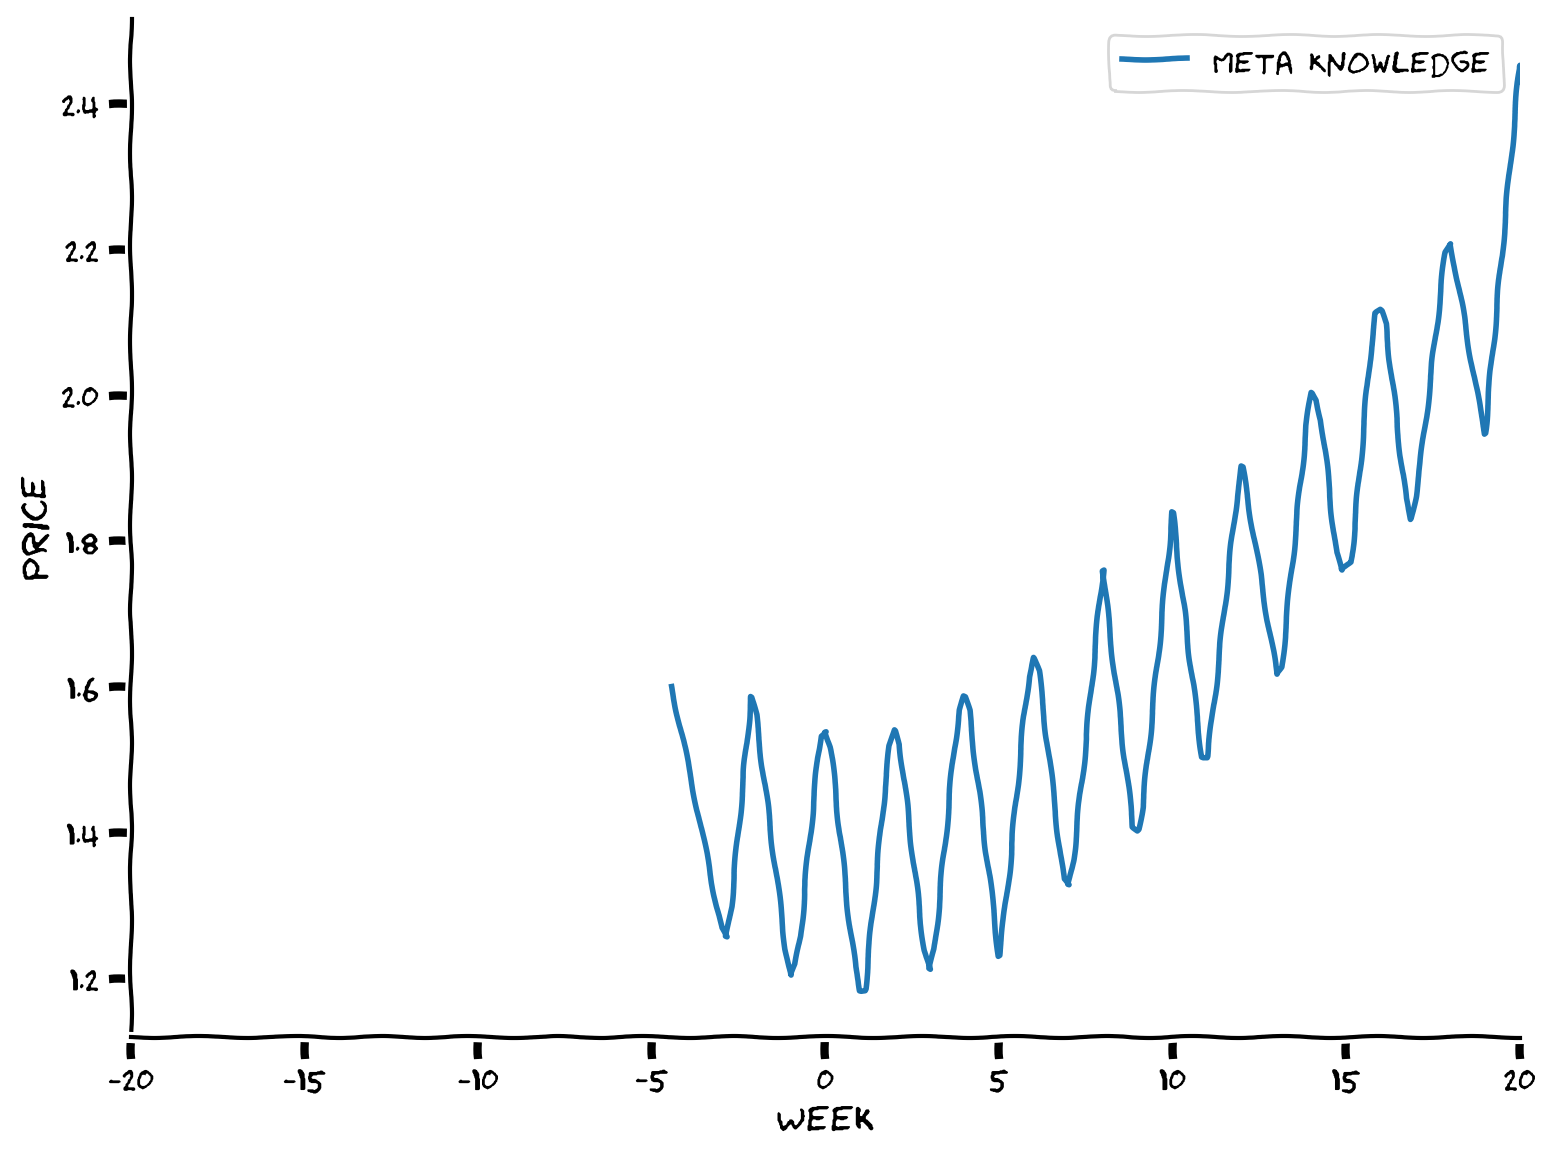

In [31]:
#make sure you have downloaded model in your files
model_path = 'SummerAutumnModel.pt'
meta_model = MetaLearningModel(model = model_path, mean = days_mean, std = days_std)
prediction = meta_model.inference(torch.tensor(np.expand_dims(days, 1)))

## UNCOMMENT TO SEE THE PLOT ##

with plt.xkcd():
     plt.plot(days, prediction.detach().numpy(), label = "Meta Knowledge")
     plt.xlabel('Week')
     plt.xlim(-20,20)
     plt.ylabel('Price')
     plt.legend()
     plt.show()

## UNCOMMENT TO SEE THE PLOT ##

**Discuss**

Does the result match your drawings?

In [23]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_dream_about_model")

# Section 3: Adapt to a particular task

*Estimated timing to here from start of tutorial: 35 minutes*


## Coding Exercise 3: Fine-tuning model

Now, we would like to evaluate the learning ability of the meta-learned model by fine-tuning it to a particular task. For that, we clone the model parameters and perform a couple of gradient descent steps on a small amount of data for two specific tasks:

$$A = 0.005, B = 0.1, \phi = 0, C = 1$$
$$A = -0.005, B = 0.1, \phi = 0, C = 4$$

Observe the second set of parameters. The model hasn't been exposed to negative values of $A$ in any of the tasks during training. We will see whether it has still learned enough to generalize well!

We will test this by completing the `finetune` function, which takes the `model`, data (`x_finetune`, `y_finetune`) sampled from the particular task, and the number of gradient descent steps to take (`finetune_gradient_steps`). We will use the Stochastic Gradient Descent optimizer to perform these steps on the cloned base parameters so that we preserve the meta-learned ones.

In [24]:
def finetune(model, x_finetune, y_finetune, finetune_gradient_steps):
    """
    Take a fixed number of gradient steps for the given x_finetune and y_finetune.

    Inputs:
    - model (MetaLearningModel): trained meta learning model.
    - x_finetune (torch.tensor): features (days) of the specific task.
    - y_finetune (torch.tensor): outcomes (prices) of the specific task.
    - finetune_gradient_steps (int): number of gradient steps to perform for this task.
    """
    #apply normalization on days
    x_finetune = (x_finetune - model.mean) / model.std

    #need to create clone, so that we preserve meta-learnt parameters
    clone = model.deep_clone_model(model.model)
    optimizer = optim.SGD(clone.parameters(), lr = model.inner_learning_rate)

    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: complete fine-tuning procedure.")
    ###################################################################

    for _ in range(finetune_gradient_steps):
        optimizer.zero_grad()
        loss = model.loss_fn(clone(x_finetune), y_finetune)
        loss.backward()
        optimizer.step()

    return clone

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial3_Solution_2753b5eb.py)



The `plot_performance` function used below implements sampling and fine-tuning on sampled data under the hood as well as predicting for all days after that.

In [25]:
def plot_performance(task, meta_model, gradient_steps, num_samples_finetune):
    """
    Plot the predictions of prices on fine-tuned model.

    Inputs:
    - task (list): Parameters of the task to be sample from.
    - meta_model (MetaLearningModel): An instance of meta-learning model initialized from the parameters file and over which fine-tuning will take place.
    - gradient_steps (int): number of steps to perform gradient descent.
    - num_samples_finetune (int) number of samples.
    """

    #sample data from the desired task
    dataset = FruitSupplyDataset(also_sample_outer = False)
    x_finetune, y_finetune = dataset.sample_particular_task(*task, num_samples_finetune)

    with plt.xkcd():
      prices = task[0] * days ** 2 + task[1] * np.sin(np.pi * days + task[2]) + task[3]
      plt.plot(days, prices, label = "True function")

      #we finetune on sampled (x_finetune, y_finetune) but calculate predictions on all days
      #`finetune_complete` is already completed version of `finetune`
      prediction = finetune_complete(meta_model, torch.tensor(x_finetune).type(torch.float32),  torch.tensor(y_finetune).type(torch.float32), gradient_steps)(torch.tensor((np.expand_dims(days, 1) - days_mean) / days_std).type(torch.float32)).detach().numpy()

      print(f"R-squared value is {r2_score(prices, prediction):.02f}")

      plt.plot(days, prediction, label=f'{gradient_steps} gradient steps')
      plt.title(f'Fine-tuned model on {num_samples_finetune} samples')
      plt.xlabel('Week')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

def visualize(name, gradient_steps, num_samples_finetune):
    """Performs fine-tuning for a couple of tasks in a row.

    Inputs:
    - name (str): Name of the model's file.
    - gradient_steps (int): number of steps to perform gradient descent.
    - num_samples_finetune (int) number of samples.
    """

    model_path = name + '.pt'
    meta_model = MetaLearningModel(model = model_path, mean = days_mean, std = days_std)

    tasks = [[0.005, 0.1, 0.0, 1.0], [-0.005, 0.1, 0.0, 4.0]]

    for task in tasks:
        fig = plot_performance(task, meta_model, gradient_steps, num_samples_finetune)

R-squared value is 0.96


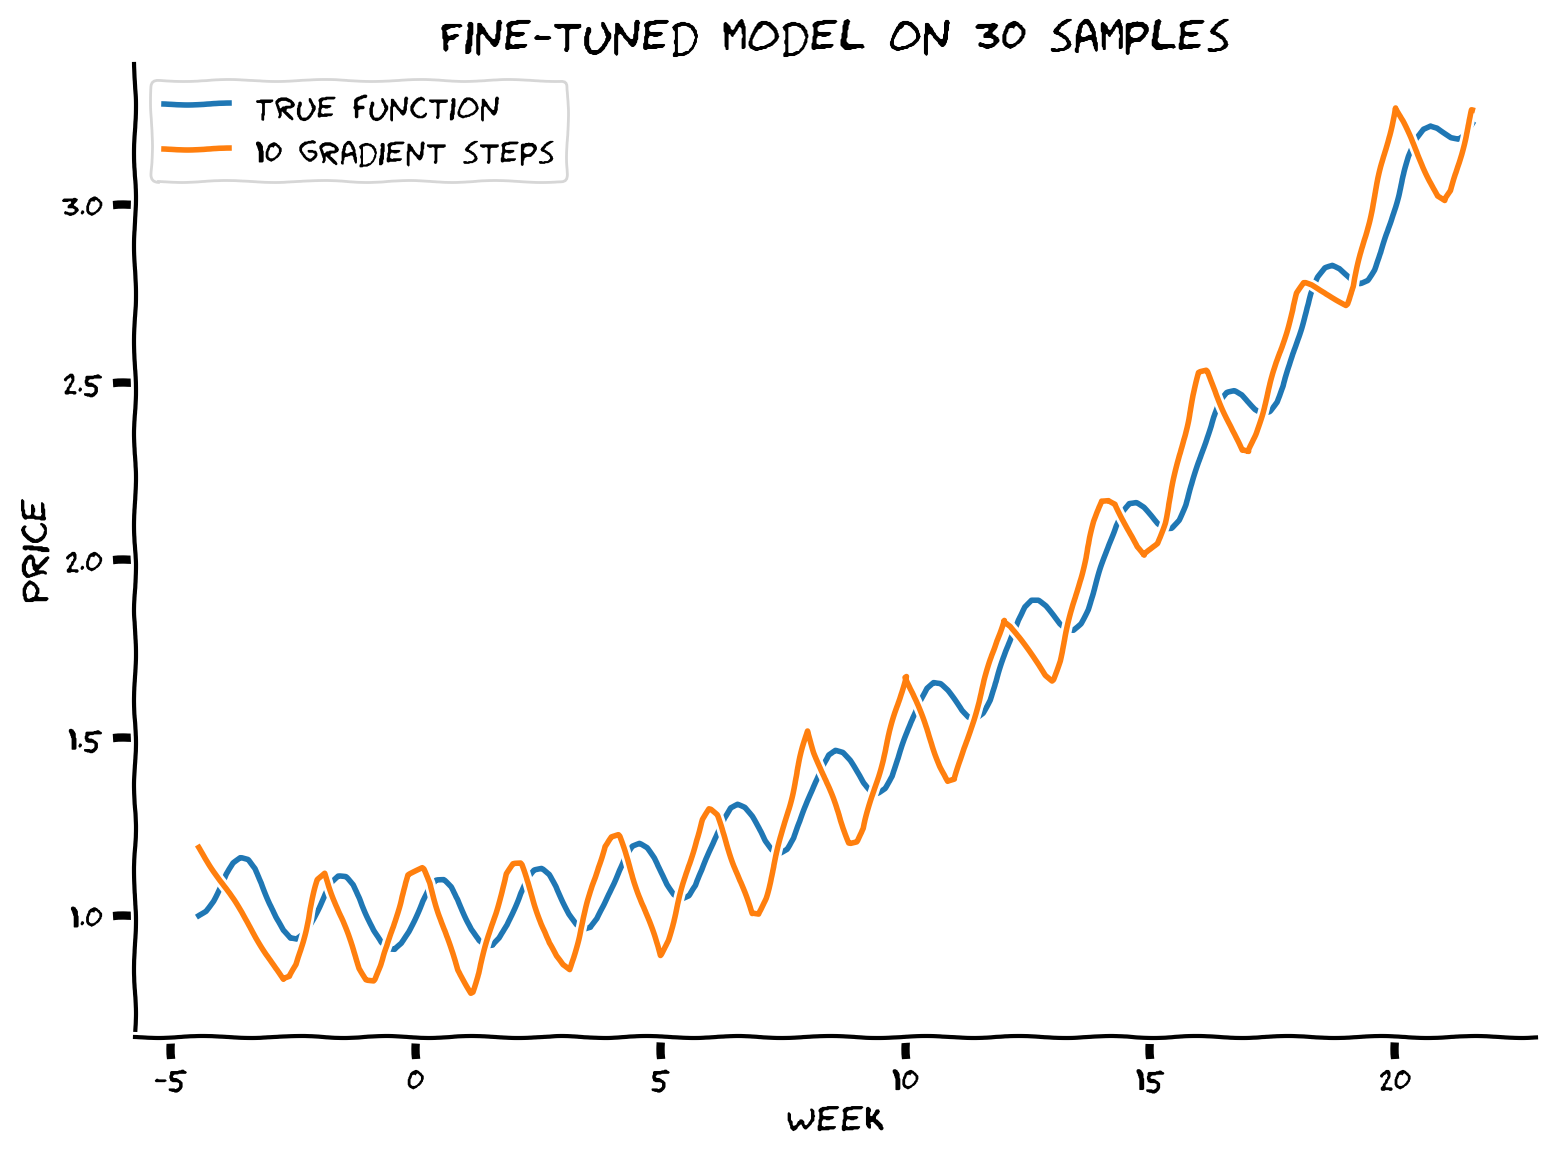

R-squared value is 0.91


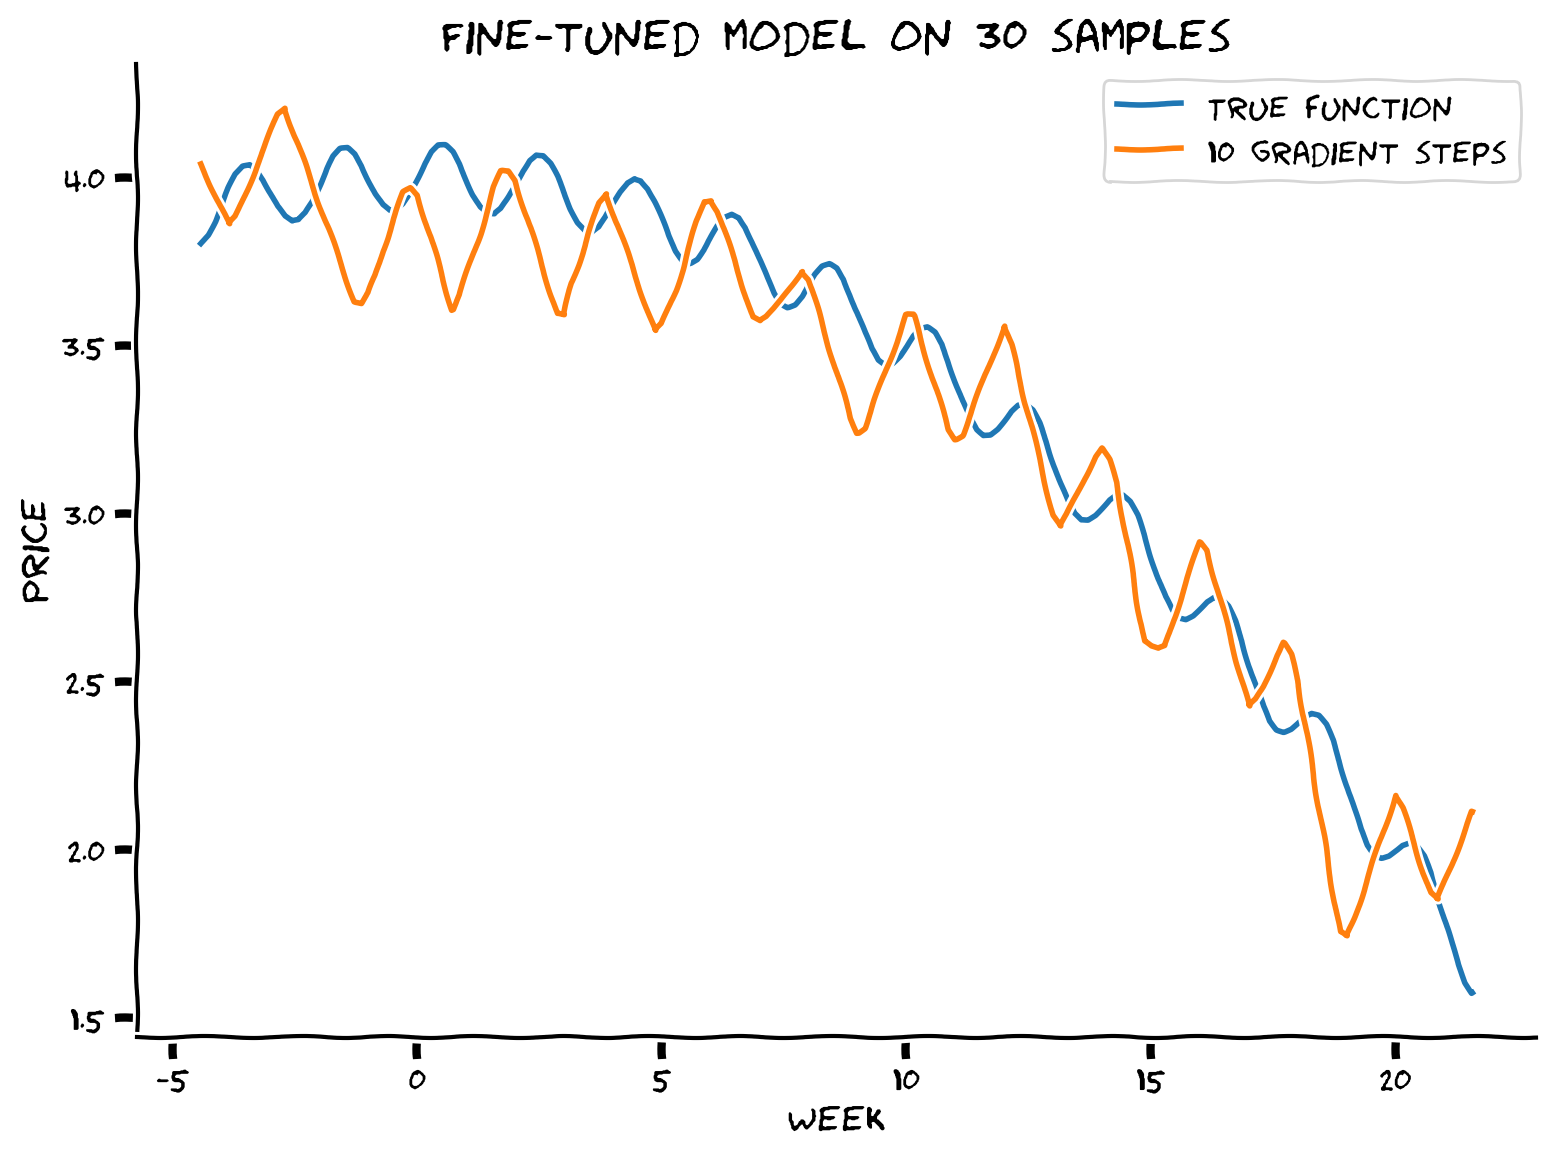

In [26]:
set_seed(42)
visualize("SummerAutumnModel", gradient_steps = 10, num_samples_finetune = 30)

In [27]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_finetuning_model")

## Interactive Demo 1: Number of data points & gradient steps

We've seen how the meta-learning procedure created a model that could quickly adapt to new tasks (including the inverted curve!). In the above examples, we used 30 samples from each task and 10 gradient steps. In this interactive demo, we invite you to explore the reasonable amount of data points to sample from a particular task and the number of gradient steps to make to fine-tune the model's performance.

What is the relationship between these two fine-tuning parameters and performance? Have you noticed any lower bounds for any of the parameters such that below these thresholds, the performance can't be expected to be great?

In [28]:
# @title Make sure you execute this cell to observe the widget!

set_seed(42)

@widgets.interact
def interactive_visualize(
    gradient_steps = widgets.IntSlider(description="Gradient Steps", min=0, max=20, step=1, value=10), num_samples =  widgets.IntSlider(description="Samples", min=5, max=150, step=5, value=100)):
    visualize("SummerAutumnModel", gradient_steps, num_samples)

interactive(children=(IntSlider(value=10, description='Gradient Steps', max=20), IntSlider(value=100, descript…

The observed interactive plots are summarized in the following 3D visualization, where the number of gradient steps and sample size are plotted against the R-squared score achieved on these particular values.

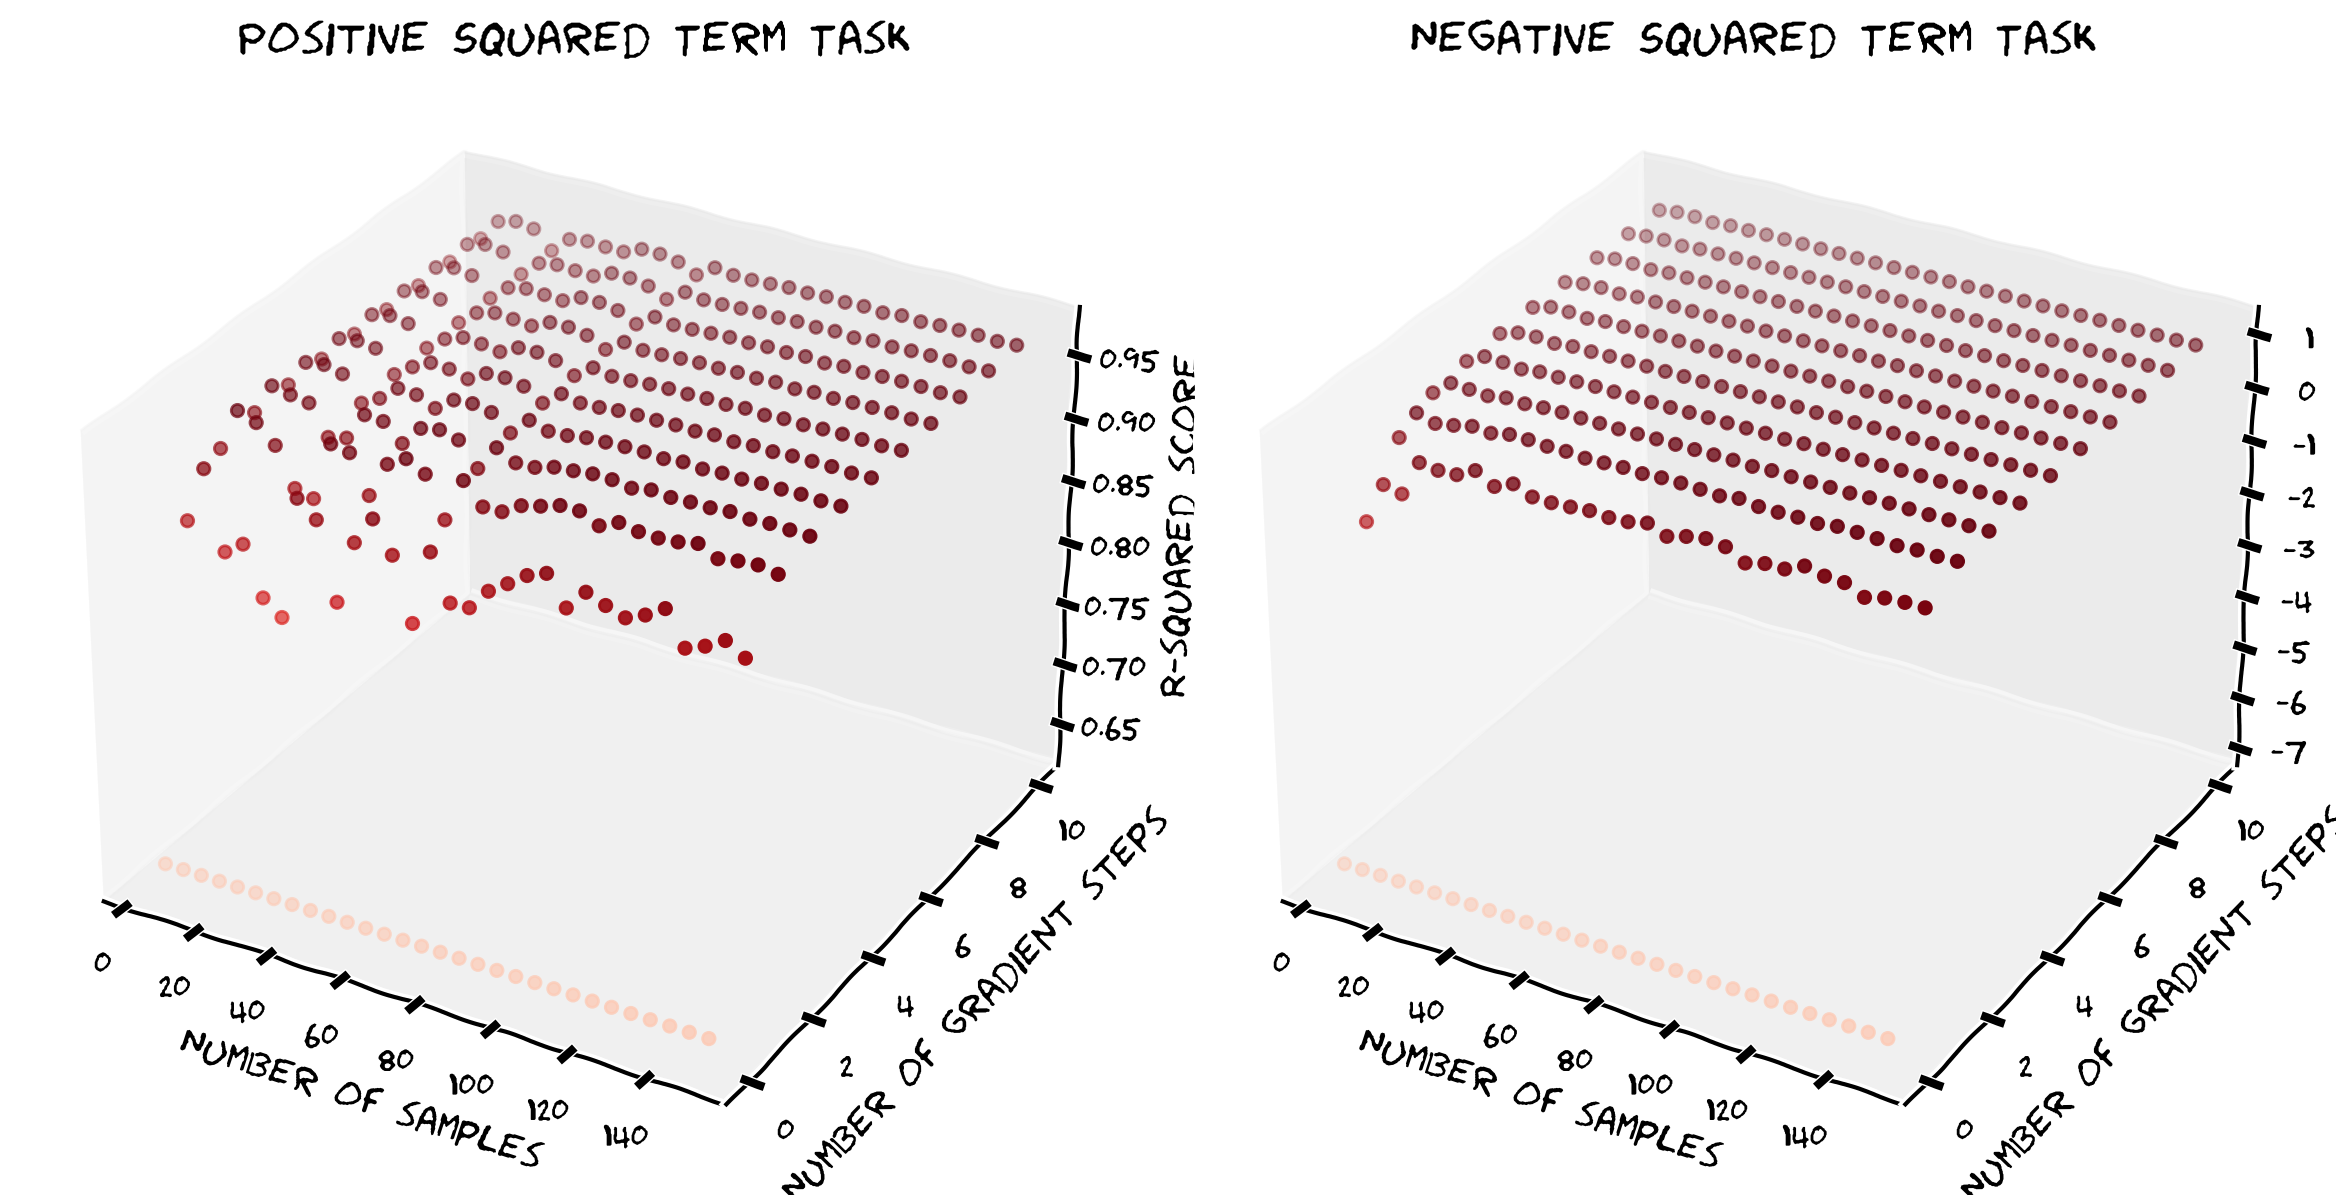

In [29]:
# @title Make sure you execute this cell to observe the plot!

set_seed(42)

gradient_steps = np.arange(11)
num_samples = np.arange(5, 155, 5)
plot_sensitivity_r_squared("SummerAutumnModel", gradient_steps, num_samples)

In [30]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_number_of_data_points_and_gradient_steps")

---
# Summary

*Estimated timing of tutorial: 50 minutes*

A summary of what we've learned:

1. Meta-learning aims to create a model that can quickly learn any task from a distribution.

2. To achieve this, it uses inner and outer learning loops to find base parameters from which a small number of gradient steps can lead to good performance on any task.